### This notebook is based on DeepGlobe Land cover classification challenge, where each pixel on a satellite image has been classified as a particular land-cover class, further divided in 7 sections, with the following pixel values 

#### Urban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)
#### Agriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.
#### Rangeland: 255,0,255 - Any non-forest, non-farm, green land, grass
#### Forest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.
#### Water: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.
#### Barren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation
#### Unknown: 0,0,0 - Clouds and others

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
!pip install keras==2.4.3

In [ ]:
# We will use the prebuilt Segmentation models library, which provides several 
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-xo_7plyr
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-xo_7plyr
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 4.3 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33809 sha256=7d145e6014390f46a98d34448228cff8869b4f159f9d20a478de7e175cb899cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvftnvqa/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
# Installing necessary libraries

from glob import glob
import re
import shutil
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import random
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras
from keras.models import load_model
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
dataset_path = "/content/drive/MyDrive/data_Globe/"
training_data = "training/"
val_data = "validation/"

In [ ]:
# Image size that we are going to use
IMG_SIZE = 512

# Our images are RGB (3 channels)
N_CHANNELS = 3

# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 7

SEED = 42
BATCH_SIZE = 4
EPOCHS = 40

In [ ]:
TRAINING_SIZE = len(glob(dataset_path + "images/" + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINING_SIZE} images.")

VAL_SIZE = len(glob(dataset_path + "images/" + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VAL_SIZE} images.")

The Training Dataset contains 643 images.
The Validation Dataset contains 160 images.


In [ ]:
# These are the following values of pixels corresponding to different classes in the masks

"""
Urban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)
Agriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.
Rangeland: 255,0,255 - Any non-forest, non-farm, green land, grass
Forest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.
Water: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.
Barren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation
Unknown: 0,0,0 - Clouds and others

"""

'\nUrban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)\nAgriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.\nRangeland: 255,0,255 - Any non-forest, non-farm, green land, grass\nForest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.\nWater: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.\nBarren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation\nUnknown: 0,0,0 - Clouds and others\n\n'

In [ ]:
class_pixels_list = [(0,0,0), (255,255,0), (255,0,255), (0,255,0), (0,0,255), (255,255,255), (0,255,255)]

In [ ]:
class_subst_list = []
for class_pixel in class_pixels_list:
  a,b,c = class_pixel
  temp = round(a * 299/1000 + b * 587/1000 + c * 114/1000, 0)
  class_subst_list.append(temp)
class_subst_list[1] = 225.0
class_subst_list[-1] = 178.0
class_subst_list[3] = 149.0
print(class_subst_list)

[0.0, 225.0, 105.0, 149.0, 29.0, 255.0, 178.0]


In [ ]:
def mapping_to_classes(x):
  mask_temp = tf.cast(tf.zeros(tf.shape(x)), tf.int32)
  for i in range(len(class_subst_list)):
    temp = tf.cast(x==tf.cast(tf.constant(class_subst_list[i]), tf.int32), tf.int32)*(i+1)
    mask_temp = mask_temp + temp
  return mask_temp

In [ ]:
def parse_image(img_path: str) -> dict:
    
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # image = tf.image.convert_image_dtype(image, tf.int32)

    """
    For one Image path:
    .../data_Globe/images/training/2345.jpg
    Its corresponding mask path is:
    .../data_Globe/masks/training/2345.png
    """
    
    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.int32)
    annot = mask
    # This mask is a 3D image, with values of pixels not representing classes
    mask = mapping_to_classes(mask)
    # mask = tf.image.convert_image_dtype(mask, tf.uint8)

    return {'image': image, 'mask': mask, 'annot': annot}

In [ ]:
train_dataset = tf.data.Dataset.list_files(dataset_path + "images/" + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + "images/" + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

In [ ]:
# Sanity check ... (1)

""" 
  The mapping_to_classes function doesnot have 0 assigned to any class [from 1...7]
  but, every iteration begins with mask_temp = 0. Hence, for all the images in the training 
  data, if any image has any class marked as 0, we might be missing any pixel to map to a class

"""
for i in train_dataset.take(TRAINING_SIZE):
  # assert tf.reduce_sum(tf.cast(i["mask"] == tf.cast(tf.constant(0), tf.int32), tf.int32)) == tf.cast(tf.constant(0), tf.int32)
  if tf.reduce_sum(tf.cast(i["mask"] == tf.cast(tf.constant(0), tf.int32), tf.int32)) > 2620:
    print(tf.reduce_sum(tf.cast(i["mask"] == tf.cast(tf.constant(0), tf.int32), tf.int32)))

Hence, we are missing some pixels to map. But such pixels atmax account for just 1% of the total image (< 1% of 512*512 pixels) Hence, its safe to just label them as class 0 (unknown)

In [ ]:
# Sanity check complete

"""
  hence, we can create the dataset object from beginning, with classes now ranging 
  from [0,...6] i.e. 7 clasees.The unknown classes pixels would also be classified as 
  along with missing classes will together be classified as unknown
  
"""

'\n  hence, we can create the dataset object from beginning, with classes now ranging \n  from [0,...6] i.e. 7 clasees.The unknown classes pixels would also be classified as \n  along with missing classes will together be classified as unknown\n  \n'

In [ ]:
# Now creating new dataset objects 

def mapping_to_classes(x):
  mask_temp = tf.cast(tf.zeros(tf.shape(x)), tf.int32)
  for i in range(len(class_subst_list)):
    temp = tf.cast(x==tf.cast(tf.constant(class_subst_list[i]), tf.int32), tf.int32)*(i)
    mask_temp = mask_temp + temp
  return mask_temp

In [ ]:
def parse_image(img_path: str) -> dict:
    
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0
    # image = tf.image.convert_image_dtype(image, tf.int32)

    """
    For one Image path:
    .../data_Globe/images/training/2345.jpg
    Its corresponding mask path is:
    .../data_Globe/masks/training/2345.png
    """
    
    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.int32)
    annot = mask
    # This mask is a 3D image, with values of pixels not representing classes
    mask = tf.squeeze(mapping_to_classes(mask), axis=-1)
    # mask = tf.keras.utils.to_categorical(mask)
    mask = tf.one_hot(mask, N_CLASSES)
    # mask = tf.image.convert_image_dtype(mask, tf.uint8)

    return {'image': image, 'mask': mask}

In [ ]:
train_dataset = tf.data.Dataset.list_files(dataset_path + "images/" + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + "images/" + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

<dtype: 'float32'>


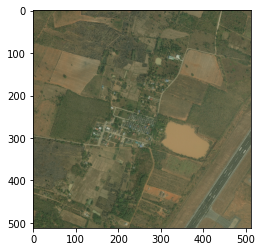

<dtype: 'float32'>


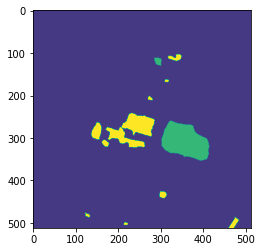

In [ ]:
# Sanity check ... (2)
for ig in train_dataset.take(1):
  plt.imshow(ig["image"])
  print(ig["image"].dtype)
  plt.show()

  plt.imshow(tf.argmax(ig["mask"], axis=-1))
  print(ig["mask"].dtype)
  plt.show()

In [ ]:
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = datapoint['image']
    input_mask = datapoint['mask']
    # input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = datapoint['image']
    input_mask = datapoint['mask']
    # input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 10

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 7)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 7)), types: (tf.float32, tf.float32)>


In [ ]:
from segmentation_models import Linknet

In [ ]:
optimizer = keras.optimizers.Adam(0.0001)

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5, name="iou"), sm.metrics.FScore(threshold=0.5, name="fscore")]

In [ ]:
# Defining Leraning rate scheduling

lr_init = 0.0001
def scheduler_3(epoch):
    
    if epoch == 0:
        return lr_init
    else:
        return lr_init*((1-epoch/100)**0.9)

## Model 1, with VGG16 encoder

In [ ]:
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_3, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_iou',mode='max',verbose=1,patience=10,restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('temp_vgg',save_weights_only=True,monitor='val_iou',mode='max',save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'content/CE')

In [ ]:
BACKBONE_1 = "vgg16"
model1 = Linknet(BACKBONE_1, encoder_weights='imagenet', classes=N_CLASSES, activation="softmax")
model1.compile(optimizer, total_loss, metrics)

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
model1_history = model1.fit(dataset['train'], epochs = EPOCHS,
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE,
                          validation_steps = VAL_SIZE // BATCH_SIZE,
                          validation_data = dataset['val'],
                          callbacks = [scheduler, earlystop, checkpoint])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
160/160 [==============================] - 175s 1s/step - loss: 0.7907 - iou: 0.1949 - fscore: 0.2686 - val_loss: 0.7767 - val_iou: 0.2153 - val_fscore: 0.2739
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 9.909954834128343e-05.
160/160 [==============================] - 119s 744ms/step - loss: 0.7469 - iou: 0.2443 - fscore: 0.3223 - val_loss: 0.8005 - val_iou: 0.1806 - val_fscore: 0.2496
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 9.819818665965754e-05.
160/160 [==============================] - 124s 774ms/step - loss: 0.7078 - iou: 0.2810 - fscore: 0.3640 - val_loss: 0.7521 - val_iou: 0.2295 - val_fscore: 0.3071
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 9.729590473501306e-05.
160/160 [==============================] - 119s 742ms/step - loss: 0.6802 - iou: 0.3049 - fscore: 0.3918 - val_loss: 0.6580 - val_iou: 0.3071 - v

In [ ]:
# Training for 10 more epochs: - 

model1_history_1 = model1.fit(dataset['train'], epochs = 10,
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE,
                          validation_steps = VAL_SIZE // BATCH_SIZE,
                          validation_data = dataset['val'],
                          callbacks = [scheduler, earlystop, checkpoint])

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
160/160 [==============================] - 127s 788ms/step - loss: 0.5250 - iou: 0.4284 - fscore: 0.5172 - val_loss: 0.5810 - val_iou: 0.3636 - val_fscore: 0.4606
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 9.909954834128343e-05.
160/160 [==============================] - 119s 747ms/step - loss: 0.5065 - iou: 0.4425 - fscore: 0.5324 - val_loss: 0.5607 - val_iou: 0.3899 - val_fscore: 0.4756
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 9.819818665965754e-05.
160/160 [==============================] - 119s 743ms/step - loss: 0.5259 - iou: 0.4262 - fscore: 0.5165 - val_loss: 0.5567 - val_iou: 0.3982 - val_fscore: 0.4824
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 9.729590473501306e-05.
160/160 [==============================] - 119s 745ms/step - loss: 0.4945 - iou: 0.4543 - fscore: 0.5445 - val_loss: 0.5307 - val_iou: 0.4189 

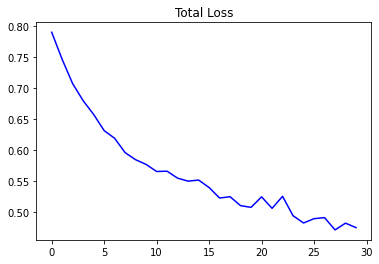

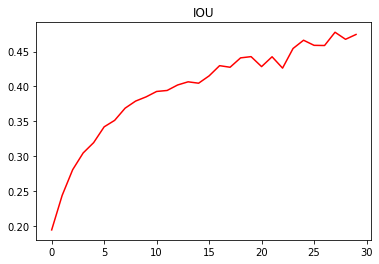

In [ ]:
# PLot the history object
plt.plot(model1_history.history["loss"] + model1_history_1.history["loss"], 'b')
plt.title("Total Loss")
plt.show()

plt.plot(model1_history.history["iou"] + model1_history_1.history["iou"], 'r')
plt.title("IOU")
plt.show()


In [ ]:
# Should be trained for another 10-15 epochs
model1_history_1 = model1.fit(dataset['train'], epochs = 9,
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE,
                          validation_steps = VAL_SIZE // BATCH_SIZE,
                          validation_data = dataset['val'],
                          callbacks = [scheduler, earlystop, checkpoint])

Epoch 1/9

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
160/160 [==============================] - 326s 2s/step - loss: 0.4637 - iou: 0.4825 - fscore: 0.5710 - val_loss: 0.5658 - val_iou: 0.3907 - val_fscore: 0.4769
Epoch 2/9

Epoch 00002: LearningRateScheduler reducing learning rate to 9.909954834128343e-05.
160/160 [==============================] - 290s 2s/step - loss: 0.4633 - iou: 0.4848 - fscore: 0.5744 - val_loss: 0.5415 - val_iou: 0.4054 - val_fscore: 0.4948
Epoch 3/9

Epoch 00003: LearningRateScheduler reducing learning rate to 9.819818665965754e-05.
160/160 [==============================] - 287s 2s/step - loss: 0.4543 - iou: 0.4939 - fscore: 0.5807 - val_loss: 0.5269 - val_iou: 0.4236 - val_fscore: 0.5154
Epoch 4/9

Epoch 00004: LearningRateScheduler reducing learning rate to 9.729590473501306e-05.
160/160 [==============================] - 290s 2s/step - loss: 0.4676 - iou: 0.4828 - fscore: 0.5692 - val_loss: 0.5185 - val_iou: 0.4280 - val_fscore: 0.

In [ ]:
model1.save('vgg16_backbone.hdf5')


## Model 2, with ResNet-34 encoder

In [ ]:
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_3, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_iou',mode='max',verbose=1,patience=10,restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('temp_res',save_weights_only=True,monitor='val_iou',mode='max',save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'content/CE')

In [ ]:
BACKBONE_2 = "resnet34"
model2 = Linknet(BACKBONE_2, encoder_weights='imagenet', classes=N_CLASSES, activation="softmax")
model2.compile(optimizer, total_loss, metrics)

85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
model2_history = model2.fit(dataset['train'], epochs = EPOCHS,
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE,
                          validation_steps = VAL_SIZE // BATCH_SIZE,
                          validation_data = dataset['val'],
                          callbacks = [scheduler, earlystop, checkpoint])

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
160/160 [==============================] - 610s 3s/step - loss: 0.9320 - iou: 0.0319 - fscore: 0.0509 - val_loss: 0.9624 - val_iou: 0.0107 - val_fscore: 0.0107
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 9.909954834128343e-05.
160/160 [==============================] - 92s 574ms/step - loss: 0.8162 - iou: 0.1498 - fscore: 0.1963 - val_loss: 0.9624 - val_iou: 0.0132 - val_fscore: 0.0208
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 9.819818665965754e-05.
160/160 [==============================] - 91s 566ms/step - loss: 0.7615 - iou: 0.2126 - fscore: 0.2720 - val_loss: 0.9615 - val_iou: 0.0225 - val_fscore: 0.0235
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 9.729590473501306e-05.
160/160 [==============================] - 93s 584ms/step - loss: 0.7276 - iou: 0.2598 - fscore: 0.3294 - val_loss: 1.0495 - val_iou: 0.0177 - val_

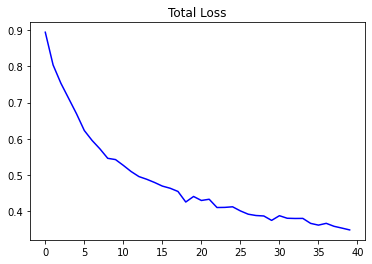

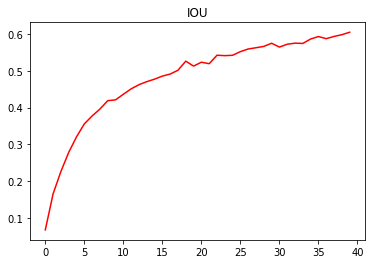

In [ ]:
# PLot the history object

plt.plot(model2_history.history["loss"],'b')
plt.title("Total Loss")
plt.show()

plt.plot(model2_history.history["iou"], 'r')
plt.title("IOU")
plt.show()

In [ ]:
model2.save('res34_backbone.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Model 3, with Inception-v3 encoder

In [ ]:
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_3, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_iou',mode='max',verbose=1,patience=10,restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('temp_inc',save_weights_only=True,monitor='val_iou',mode='max',save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'content/CE')

In [ ]:
BACKBONE_3 = "inceptionv3"
model3 = Linknet(BACKBONE_3, encoder_weights='imagenet', classes=N_CLASSES, activation="softmax")
model3.compile(optimizer, total_loss, metrics)

87916544/87910968 [==============================] - 4s 0us/step


In [ ]:
model3_history = model3.fit(dataset['train'], epochs = EPOCHS,
                          steps_per_epoch = TRAINING_SIZE // BATCH_SIZE,
                          validation_steps = VAL_SIZE // BATCH_SIZE,
                          validation_data = dataset['val'],
                          callbacks = [scheduler, earlystop, checkpoint])

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
160/160 [==============================] - 606s 3s/step - loss: 0.9346 - iou: 0.0315 - fscore: 0.0511 - val_loss: 0.8439 - val_iou: 0.1564 - val_fscore: 0.2130
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 9.909954834128343e-05.
160/160 [==============================] - 103s 646ms/step - loss: 0.8082 - iou: 0.1832 - fscore: 0.2495 - val_loss: 0.7243 - val_iou: 0.2515 - val_fscore: 0.3088
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 9.819818665965754e-05.
160/160 [==============================] - 108s 678ms/step - loss: 0.7402 - iou: 0.2431 - fscore: 0.3145 - val_loss: 0.6901 - val_iou: 0.2853 - val_fscore: 0.3713
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 9.729590473501306e-05.
160/160 [==============================] - 103s 641ms/step - loss: 0.6978 - iou: 0.2989 - fscore: 0.3880 - val_loss: 0.6628 - val_iou: 0.3143 - v

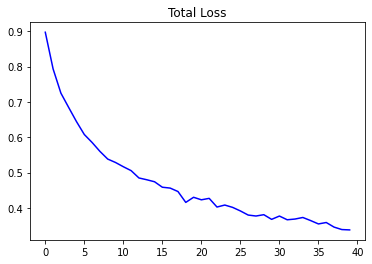

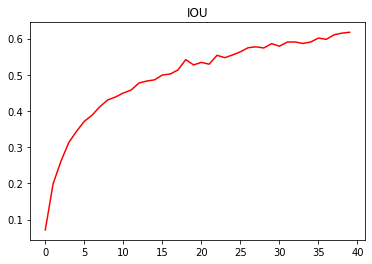

In [ ]:
# PLot the history object

plt.plot(model3_history.history["loss"],'b')
plt.title("Total Loss")
plt.show()

plt.plot(model3_history.history["iou"], 'r')
plt.title("IOU")
plt.show()

In [ ]:
model3.save('incep_backbone.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Trying the same task with a segmentation of these models

In [ ]:
TEST_IMAGES_PATH = glob(dataset_path + "images/" + val_data +"*.jpg")
TEST_MASKS_PATH = glob(dataset_path + "masks/" + val_data +"*.png")

TEST_IMAGES_PATH.sort()
TEST_MASKS_PATH.sort()

In [ ]:
# Sanity check ...(3)
# To check if both the lists are in same order


for i in range(len(TEST_IMAGES_PATH)):
  mask_1 = re.sub("images", "masks", TEST_IMAGES_PATH[i])
  mask_1 = re.sub("jpg", "png", mask_1)

  mask_2 = TEST_MASKS_PATH[i]

  if mask_1 != mask_2:
    print(mask_1)
    print(mask_2)

In [ ]:
""" Creating the test images and masks """


test_images_list = []
test_masks_list = []

for path in TEST_IMAGES_PATH:
  image = tf.io.read_file(path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0
  
  test_images_list.append(image)
  
  mask_path = tf.strings.regex_replace(path, "images", "masks")
  mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
  mask = tf.cast(mask, tf.int32)
  mask = mapping_to_classes(mask)

  test_masks_list.append(mask)


X_test = tf.stack(test_images_list, axis=0)
Y_test = tf.stack(test_masks_list, axis=0)

del test_images_list
del test_masks_list

In [ ]:
model1 = load_model('/content/drive/MyDrive/vgg16_backbone.hdf5', compile=False)
model2 = load_model('/content/drive/MyDrive/res34_backbone.hdf5', compile=False)
model3 = load_model('/content/drive/MyDrive/incep_backbone.hdf5', compile=False)

In [ ]:
# df = pd.DataFrame([])
# preds = tf.stack([model1.predict(X_test), model2.predict(X_test), model3.predict(X_test)], axis=0)

from keras.metrics import MeanIoU

for w1 in range(0, 4):
    for w2 in range(0,4):
        for w3 in range(0,4):
            wts = [w1/10.,w2/10.,w3/10.]
            
            IOU_wted = MeanIoU(num_classes=N_CLASSES) 
            wted_preds = tf.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = tf.argmax(wted_preds, axis=3)
            IOU_wted.update_state(Y_test[:,:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)

Now predciting for weights : 0.0 0.0 0.0  : IOU =  0.00054073887
Now predciting for weights : 0.0 0.0 0.1  : IOU =  0.55015373
Now predciting for weights : 0.0 0.0 0.2  : IOU =  0.55015373
Now predciting for weights : 0.0 0.0 0.3  : IOU =  0.55015373
Now predciting for weights : 0.0 0.1 0.0  : IOU =  0.54792696
Now predciting for weights : 0.0 0.1 0.1  : IOU =  0.5565101
Now predciting for weights : 0.0 0.1 0.2  : IOU =  0.5523268
Now predciting for weights : 0.0 0.1 0.3  : IOU =  0.5515081
Now predciting for weights : 0.0 0.2 0.0  : IOU =  0.54792696
Now predciting for weights : 0.0 0.2 0.1  : IOU =  0.55019814
Now predciting for weights : 0.0 0.2 0.2  : IOU =  0.5565101
Now predciting for weights : 0.0 0.2 0.3  : IOU =  0.55335844
Now predciting for weights : 0.0 0.3 0.0  : IOU =  0.54792696
Now predciting for weights : 0.0 0.3 0.1  : IOU =  0.5493158
Now predciting for weights : 0.0 0.3 0.2  : IOU =  0.55134106
Now predciting for weights : 0.0 0.3 0.3  : IOU =  0.5565104
Now predcit

In [ ]:
max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2])   

Max IOU of  0.5770232081413269  obained with w1= 0.3  w2= 0.2  and w3= 0.2


# **Results for prediction on test dataset**

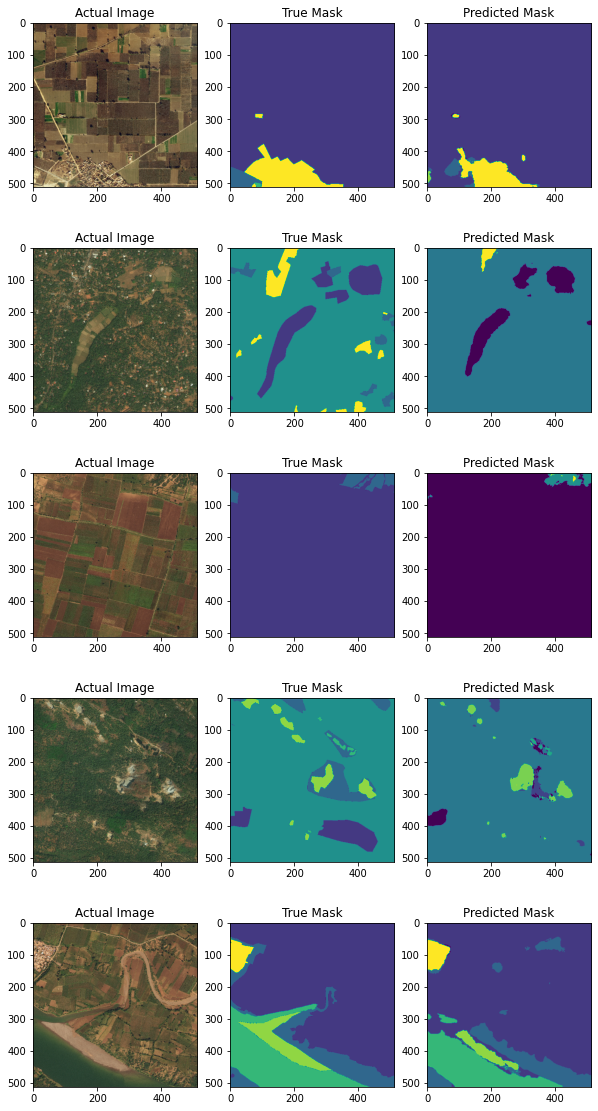

In [ ]:
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]

l = np.arange(X_test.shape[0])
np.random.seed(30)
np.random.shuffle(l)
l = list(l)

fig, axs = plt.subplots(nrows = 5, ncols = 3, figsize=(10, 20))

for i in range(5):
  test_img = X_test[l[i],:,:,:]
  test_img = test_img
  test_img = tf.expand_dims(test_img, axis=0)
  axs[i][0].imshow(tf.squeeze(test_img, axis=0))
  axs[i][0].set_title("Actual Image")
  
  test_mask = tf.squeeze(Y_test[l[i],:,:,:], axis=-1)
  axs[i][1].imshow(test_mask)
  axs[i][1].set_title("True Mask")

  test_pred1 = model1.predict(test_img)
  test_pred2 = model2.predict(test_img)
  test_pred3 = model3.predict(test_img)

  predictions = tf.squeeze(max_iou_row[0]*test_pred1 + max_iou_row[1]*test_pred2 + max_iou_row[2]*test_pred3, axis=0)
  
  weighted_ensemble = tf.argmax(predictions, axis=-1)

  axs[i][2].imshow(weighted_ensemble)
  axs[i][2].set_title('Predicted Mask')

plt.show()

#### **As can be clearly seen, the ensemble predictins are great. The probable differences in color codings for same class in actual and predictions should not be misinterpreted. The Actual masks represents grayscale outputs of original masks, where as the predictions masks are class representations, hence are integers b/w [0,1,...6].**